TensorFLowによって2値分類を行うサンプルコードを載せました。今回はこれをベースにして進めます。


tf.kerasやtf.estimatorなどの高レベルAPIは使用していません。低レベルなところから見ていくことにします。

# 【問題1】スクラッチを振り返る
ここまでのスクラッチを振り返り、ディープラーニングを実装するためにはどのようなものが必要だったかを列挙してください。


（例）


重みを初期化する必要があった

エポックのループが必要だった

それらがフレームワークにおいてはどのように実装されるかを今回覚えていきましょう。


### データセットの用意
以前から使用しているIrisデータセットを使用します。以下のサンプルコードではIris.csvが同じ階層にある想定です。


[Iris Species](https://www.kaggle.com/uciml/iris/data)


目的変数はSpeciesですが、3種類ある中から以下の2種類のみを取り出して使用します。

Iris-versicolor
Iris-virginica

### 【解答】

__ディープラーニングの実装に必要だったもの__

* 活性化関数
* 誤差関数
* 全結合層
* エポックとミニバッチ
* オプティマイザ


# 【問題2】スクラッチとTensorFlowの対応を考える
以下のサンプルコードを見て、先ほど列挙した「ディープラーニングを実装するために必要なもの」がTensorFlowではどう実装されているかを確認してください。


それを簡単に言葉でまとめてください。単純な一対一の対応であるとは限りません。


### 《サンプルコード》


＊バージョン1.5から1.14の間で動作を確認済みです。

In [3]:
"""
TensorFlowで実装したニューラルネットワークを使いIrisデータセットを2値分類する
"""
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
# データセットの読み込み
dataset_path ="datasets_19_420_Iris.csv" #csv読み込み
df = pd.read_csv(dataset_path) # dataframe化

# データフレームから条件抽出
# Xとyを作成
df = df[(df["Species"] == "Iris-versicolor")|(df["Species"] == "Iris-virginica")]
y = df["Species"]
X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
y = np.array(y)
X = np.array(X)

# ラベルを数値に変換
# ついでにyを二次元に
y[y=='Iris-versicolor'] = 0
y[y=='Iris-virginica'] = 1
y = y.astype(np.int)[:, np.newaxis]
# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

# ミニバッチクラス
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]
    

# ハイパーパラメータの設定
learning_rate = 0.01 # 学習率
batch_size = 10 # バッチサイズ
num_epochs = 10 # エポック数
n_hidden1 = 50 # 隠れ層の出力サイズ
n_hidden2 = 100 # 隠れ層の出力サイズ２
n_input = X_train.shape[1] # インプットの列数、特徴量数
n_samples = X_train.shape[0] # インプットの行数、データ数
n_classes = 1 # クラス数？

# 計算グラフに渡す引数の形を決める
# https://note.nkmk.me/python-tensorflow-constant-variable-placeholder/
X = tf.placeholder("float", [None, n_input]) # プレースホルダーはデータが格納される入れ物。データは未定のままグラフを構築し、具体的な値は実行する時に与える。
Y = tf.placeholder("float", [None, n_classes])

# trainのミニバッチイテレータ
get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)

# ここが計算グラフのところ？ネットワーク作成関数。スクラッチの時で言えばSimpleConvnetあたりか。
def example_net(x):
    """
    単純な3層ニューラルネットワーク
    """
    # 重みとバイアスの宣言
    # tf.Variableで変数の宣言。中身はtf.random_normalでランダムに作成。np.random.normalみたいなもんか
    weights = {
        'w1': tf.Variable(tf.random_normal([n_input, n_hidden1])),
        'w2': tf.Variable(tf.random_normal([n_hidden1, n_hidden2])),
        'w3': tf.Variable(tf.random_normal([n_hidden2, n_classes]))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden1])),
        'b2': tf.Variable(tf.random_normal([n_hidden2])),
        'b3': tf.Variable(tf.random_normal([n_classes]))
    }
    
    # レイヤーイテレータ。tf.matmulは行列積。np.dotみたいなもの。微妙に挙動違うっぽいので要確認。
    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    layer_output = tf.matmul(layer_2, weights['w3']) + biases['b3'] # tf.addと+は等価である
    return layer_output


# ネットワーク構造の読み込み                               
logits = example_net(X)
# 目的関数
# sigmoid_cross_entropy_with_logitsはシグモイド関数を通してクロスエントロピー誤差を算出する
# 中身はz * -log(sigmoid(x)) + (1 - z) * -log(1 - sigmoid(x)) x=logits, z=labels
# ラベルかけるマイナスlog(シグモイド(X)) + (1-ラベル)かけるマイナスlog(1 - シグモイド(X))
# 0以下の場合は0を出すので、まとめるとmax(x, 0) - x * z + log(1 + exp(-abs(x)))こうなる
# reduce_meanはnp.meanと同じ、axis=Noneだと単一のスカラーが返ってくる
loss_op = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=Y, logits=logits))
# 最適化手法
# インスタンス化
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
# minimize()で呼び出し
train_op = optimizer.minimize(loss_op)
# 推定結果
# tf.equalは比較して同じだったらTrue、違えばFalseをarrayで返す
# signはサイン波に変換してる、-0.5する意味はよくわかってない
correct_pred = tf.equal(tf.sign(Y - 0.5), tf.sign(tf.sigmoid(logits) - 0.5))
# 指標値計算
# castはテンソルの型を変更する。np.astypeみたいな感じ？
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# variableの初期化をするインスタンス
# This is just a shortcut for `variables_initializer(global_variables())`
init = tf.global_variables_initializer()

# 計算グラフの実行
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(num_epochs):
        # エポックごとにループ
        total_batch = np.ceil(X_train.shape[0]/batch_size).astype(np.int)
        total_loss = 0
        total_acc = 0
        for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
            # ミニバッチごとにループ
            sess.run(train_op, feed_dict={X: mini_batch_x, Y: mini_batch_y})
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: mini_batch_x, Y: mini_batch_y})
            total_loss += loss
            total_acc += acc
        total_loss /= n_samples
        total_acc /= n_samples
        val_loss, val_acc = sess.run([loss_op, accuracy], feed_dict={X: X_val, Y: y_val})
        print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}, acc : {:.3f}, val_acc : {:.3f}".format(epoch, loss, val_loss, acc, val_acc))
    test_acc = sess.run(accuracy, feed_dict={X: X_test, Y: y_test})
    print("test_acc : {:.3f}".format(test_acc))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 0, loss : 20.0999, val_loss : 48.3906, acc : 0.750, val_acc : 0.375
Epoch 1, loss : 35.3637, val_loss : 17.8348, acc : 0.250, val_acc : 0.625
Epoch 2, loss : 4.6430, val_loss : 12.4097, acc : 0.750, val_acc : 0.375
Epoch 3, loss : 0.4239, val_loss : 3.4644, acc : 0.750, val_acc : 0.500
Epoch 4, loss : 1.2481, val_loss : 3.8557, acc : 0.750, val_acc : 0.750
Epoch 5, loss : 0.0130, val_loss : 3.3686, acc : 1.000, val_acc : 0.625
Epoch 6, loss : 0.0354, val_loss : 3.1664, acc : 1.000, val_acc : 0.750
Epoch 7, loss : 0.0000, val_loss : 1.7503, acc : 1.000, val_acc : 0.812
Epoch 8, loss : 0.0270, val_loss : 4.1209, acc : 1.000, val_acc : 0.750
Epoch 9, loss : 0.0189, val_loss : 4.2885, acc : 1.000, val_acc : 0.625
test_acc : 0.750


### 【解答及びメモ】

* tensorflowは変数とか先に宣言する。オブジェクト型ではない？
* 考えたらC++で動いてるから当たり前か。入り口がpythonで書けるというだけで中身がC++なら、基本はC系統だと思っておいた方が良さそう。


__自作CNNとの相関__
* 活性化関数　→ レイヤーのイテレータを通している。tf.nn.relu()でやってる、relu部分を変えられる。
* 誤差関数　→ tf.nn.sigmoid_cross_entropy_with_logitsで実装
* 全結合層　→ イテレータlayerで実装、logitsにネットワーク構造が入ってて、loss_opが走るとフォワードプロパゲーション、train_opで損失関数と勾配更新まで行う。このモデルではAdamOptimizerが使用されてる。
* エポックとミニバッチ　→ ここはおんなじ。ミニバッチ関数とエポックは普通にfor文
* オプティマイザ　→ インスタンス化してminimize()で呼び出し。

## 3,他のデータセットへの適用

これまで扱ってきた小さなデータセットがいくつかあります。上記サンプルコードを書き換え、これらに対して学習・推定を行うニューラルネットワークを作成してください。


* Iris（3種類全ての目的変数を使用）
* House Prices

どのデータセットもtrain, val, testの3種類に分けて使用してください。

# 【問題3】3種類全ての目的変数を使用したIrisのモデルを作成
Irisデータセットのtrain.csvの中で、目的変数Speciesに含まれる3種類全てを分類できるモデルを作成してください。


[Iris Species](https://www.kaggle.com/uciml/iris/data)


2クラスの分類と3クラス以上の分類の違いを考慮してください。それがTensorFlowでどのように書き換えられるかを公式ドキュメントなどを参考に調べてください。


《ヒント》


以下の2箇所は2クラス分類特有の処理です。

In [ ]:
loss_op = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=Y, logits=logits))

In [ ]:
correct_pred = tf.equal(tf.sign(Y - 0.5), tf.sign(tf.sigmoid(logits) - 0.5))

メソッドは以下のように公式ドキュメントを確認してください。


[tf.nn.sigmoid_cross_entropy_with_logits  |  TensorFlow](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits)


[tf.math.sign  |  TensorFlow](https://www.tensorflow.org/api_docs/python/tf/math/sign)


＊tf.signとtf.math.signは同じ働きをします。

### 【解答】

In [140]:
import sys
"""
TensorFlowで実装したニューラルネットワークを使いIrisデータセットを3値分類する
"""

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
# データセットの読み込み
dataset_path ="datasets_19_420_Iris.csv" #csv読み込み
df = pd.read_csv(dataset_path) # dataframe化

# データフレームから条件抽出
# Xとyを作成
#df = df[(df["Species"] == "Iris-versicolor")|(df["Species"] == "Iris-virginica")]
y = df["Species"]
#display(y)
X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
y = np.array(y)
X = np.array(X)

# ラベルをone-hot-vectorに変換
# ついでにyを二次元に
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y = enc.fit_transform(y[:, np.newaxis])
#print(y.shape)
#display(y)

# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
#print(X_train.shape)

# ミニバッチクラス
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]
    

# ハイパーパラメータの設定
learning_rate = 0.01 # 学習率
batch_size = 10 # バッチサイズ
num_epochs = 10 # エポック数
n_hidden1 = 50 # 隠れ層の出力サイズ
n_hidden2 = 100 # 隠れ層の出力サイズ２
n_input = X_train.shape[1] # インプットの列数、特徴量数
n_samples = X_train.shape[0] # インプットの行数、データ数
n_classes = 3 # クラス数。二値分類で１列で済むなら1で良いけど、one-hotしてるならその分増やす。今回は3。

# 計算グラフに渡す引数の形を決める
# https://note.nkmk.me/python-tensorflow-constant-variable-placeholder/
X = tf.placeholder("float", [None, n_input]) # プレースホルダーはデータが格納される入れ物。データは未定のままグラフを構築し、具体的な値は実行する時に与える。
Y = tf.placeholder("float", [None, n_classes])

# trainのミニバッチイテレータ
get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)

# ここが計算グラフのところ？ネットワーク作成関数。スクラッチの時で言えばSimpleConvnetあたりか。
def example_net(x):
    """
    単純な3層ニューラルネットワーク
    """
    # 重みとバイアスの宣言
    # tf.Variableで変数の宣言。中身はtf.random_normalでランダムに作成。np.random.normalみたいなもんか
    weights = {
        'w1': tf.Variable(tf.random_normal([n_input, n_hidden1], seed=128)),
        'w2': tf.Variable(tf.random_normal([n_hidden1, n_hidden2], seed=128)),
        'w3': tf.Variable(tf.random_normal([n_hidden2, n_classes], seed=128))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden1], seed=128)),
        'b2': tf.Variable(tf.random_normal([n_hidden2], seed=128)),
        'b3': tf.Variable(tf.random_normal([n_classes], seed=128))
    }
    
    # レイヤーイテレータ。tf.matmulは行列積。np.dotみたいなもの。微妙に挙動違うっぽいので要確認。
    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
    #print(layer_1)
    layer_1 = tf.nn.relu(layer_1)
    #print(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    #print(layer_2)
    layer_2 = tf.nn.relu(layer_2)
    #print(layer_2)
    layer_output = tf.matmul(layer_2, weights['w3']) + biases['b3'] # tf.addと+は等価である
    #print(layer_output)
    return layer_output


# ネットワーク構造の読み込み                               
logits = example_net(X)
# 目的関数
# sigmoid_cross_entropy_with_logitsはシグモイド関数を通してクロスエントロピー誤差を算出する
# 中身はz * -log(sigmoid(x)) + (1 - z) * -log(1 - sigmoid(x)) x=logits, z=labels
# ラベルかけるマイナスlog(シグモイド(X)) + (1-ラベル)かけるマイナスlog(1 - シグモイド(X))
# 0以下の場合は0を出すので、まとめるとmax(x, 0) - x * z + log(1 + exp(-abs(x)))こうなる
# reduce_meanはnp.meanと同じ、axis=Noneだと単一のスカラーが返ってくる
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=Y, logits=logits))
# 最適化手法
# インスタンス化
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
# minimize()で呼び出し
train_op = optimizer.minimize(loss_op)
# 推定結果
# tf.equalは比較して同じだったらTrue、違えばFalseをarrayで返す
# signはサイン波に変換してる、-0.5する意味はよくわかってない
softmax_out = tf.nn.softmax(logits, axis=1)
correct_pred = tf.equal(tf.argmax(Y, 1), tf.argmax(softmax_out, 1))
#correct_pred = tf.equal(tf.argmax(Y), tf.argmax(softmax_out))
# 指標値計算
# castはテンソルの型を変更する。np.astypeみたいな感じ？
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# variableの初期化をするインスタンス
# This is just a shortcut for `variables_initializer(global_variables())`
init = tf.global_variables_initializer()

# ここまでで宣言や初期化が完了、↓でコンパイル。


# 計算グラフの実行
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(num_epochs):
        # エポックごとにループ
        total_batch = np.ceil(X_train.shape[0]/batch_size).astype(np.int)
        total_loss = 0
        total_acc = 0
        for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
            # ミニバッチごとにループ
            sess.run(train_op, feed_dict={X: mini_batch_x, Y: mini_batch_y})
            #print(sess.run(train_op, feed_dict={X: mini_batch_x, Y: mini_batch_y}))
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: mini_batch_x, Y: mini_batch_y})
            #print(sess.run(loss_op, feed_dict={X: mini_batch_x, Y: mini_batch_y}))
            total_loss += loss
            total_acc += acc
        total_loss /= n_samples
        total_acc /= n_samples
        val_loss, val_acc = sess.run([loss_op, accuracy], feed_dict={X: X_val, Y: y_val})
        print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}, acc : {:.3f}, val_acc : {:.3f}".format(epoch, loss, val_loss, acc, val_acc))
    test_acc = sess.run(accuracy, feed_dict={X: X_test, Y: y_test})
    print("test_acc : {:.3f}".format(test_acc))


Epoch 0, loss : 1.7809, val_loss : 2.5576, acc : 0.667, val_acc : 0.542
Epoch 1, loss : 0.7699, val_loss : 2.8283, acc : 0.833, val_acc : 0.750
Epoch 2, loss : 0.0000, val_loss : 2.8492, acc : 1.000, val_acc : 0.792
Epoch 3, loss : 0.0001, val_loss : 4.7234, acc : 1.000, val_acc : 0.750
Epoch 4, loss : 0.5868, val_loss : 8.1870, acc : 0.833, val_acc : 0.667
Epoch 5, loss : 0.0001, val_loss : 5.3880, acc : 1.000, val_acc : 0.708
Epoch 6, loss : 0.0000, val_loss : 2.2441, acc : 1.000, val_acc : 0.833
Epoch 7, loss : 0.0000, val_loss : 1.5002, acc : 1.000, val_acc : 0.917
Epoch 8, loss : 0.0000, val_loss : 2.1333, acc : 1.000, val_acc : 0.917
Epoch 9, loss : 0.0000, val_loss : 5.2664, acc : 1.000, val_acc : 0.708
test_acc : 0.967


# 【問題4】House Pricesのモデルを作成
回帰問題のデータセットであるHouse Pricesを使用したモデルを作成してください。


[House Prices: Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)


この中のtrain.csvをダウンロードし、目的変数としてSalePrice、説明変数として、GrLivAreaとYearBuiltを使ってください。説明変数はさらに増やしても構いません。


分類問題と回帰問題の違いを考慮してください。

### 【解答】

In [162]:
#import os
#import random
#os.environ['PYTHONHASHSEED'] = "0"
#np.random.seed(0)
#random.seed(0)

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
"""
TensorFlowで実装したニューラルネットワークを使いHousePriceデータセットを回帰分類する
"""




# データセットの読み込み
dataset_path ="train.csv" #csv読み込み
df = pd.read_csv(dataset_path) # dataframe化

# データフレームから条件抽出
# Xとyを作成
#df = df[(df["Species"] == "Iris-versicolor")|(df["Species"] == "Iris-virginica")]
y = df.loc[:,["SalePrice"]]
#display(y)
X = df.loc[:, ["GrLivArea", "YearBuilt"]]
y = np.array(y)
X = np.array(X)

#print(y.shape)
#print(X.shape)


# 特徴量を標準化
scaler = StandardScaler()
X = scaler.fit_transform(X)
# 目的変数を対数変換
y = np.log1p(y)


# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
#print(X_train.shape)

#plt.scatter(X_test[:,0],y_test)
#plt.show()


# ハイパーパラメータの設定
learning_rate = 0.01 # 学習率
batch_size = 10 # バッチサイズ
num_epochs = 10 # エポック数
n_hidden1 = 50 # 隠れ層の出力サイズ
n_hidden2 = 100 # 隠れ層の出力サイズ２
n_input = X_train.shape[1] # インプットの列数、特徴量数
n_samples = X_train.shape[0] # インプットの行数、データ数
n_classes = 1 # クラス数。二値分類で１列で済むなら1で良いけど、one-hotしてるならその分増やす。今回は3。

# 計算グラフに渡す引数の形を決める
# https://note.nkmk.me/python-tensorflow-constant-variable-placeholder/
X = tf.placeholder("float", [None, n_input]) # プレースホルダーはデータが格納される入れ物。データは未定のままグラフを構築し、具体的な値は実行する時に与える。
Y = tf.placeholder("float", [None, n_classes])

# trainのミニバッチイテレータ
get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)



# ここが計算グラフのところ？ネットワーク作成関数。スクラッチの時で言えばSimpleConvnetあたりか。
def example_net(x):
    """
    単純な3層ニューラルネットワーク
    """
    # 重みとバイアスの宣言
    # tf.Variableで変数の宣言。中身はtf.random_normalでランダムに作成。np.random.normalみたいなもんか
    weights = {
        'w1': tf.Variable(tf.random_normal([n_input, n_hidden1], seed=0)),
        'w2': tf.Variable(tf.random_normal([n_hidden1, n_hidden2], seed=0)),
        'w3': tf.Variable(tf.random_normal([n_hidden2, n_classes], seed=0))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden1], seed=0)),
        'b2': tf.Variable(tf.random_normal([n_hidden2], seed=0)),
        'b3': tf.Variable(tf.random_normal([n_classes], seed=0))
    }
    
    # レイヤーイテレータ。tf.matmulは行列積。np.dotみたいなもの。微妙に挙動違うっぽいので要確認。
    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
    #print(layer_1)
    layer_1 = tf.nn.relu(layer_1)
    #print(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    #print(layer_2)
    layer_2 = tf.nn.relu(layer_2)
    #print(layer_2)
    layer_output = tf.matmul(layer_2, weights['w3']) + biases['b3'] # tf.addと+は等価である
    #print(layer_output)
    return layer_output


# ネットワーク構造の読み込み                               
logits = example_net(X)
# 目的関数
#loss_op = tf.reduce_mean(tf.squared_difference(Y, logits))
loss_op = tf.reduce_mean(tf.square(logits - Y))
# 最適化手法
# インスタンス化
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
#optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate)
# minimize()で呼び出し
train_op = optimizer.minimize(loss_op)
# 推定結果
#correct_pred = logits
# 指標値計算
# castはテンソルの型を変更する。np.astypeみたいな感じ？
#accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
accuracy = tf.reduce_mean(tf.squared_difference(Y, logits))

# variableの初期化をするインスタンス
# This is just a shortcut for `variables_initializer(global_variables())`
init = tf.global_variables_initializer()

# ここまでで宣言や初期化が完了、↓でコンパイル。



# 計算グラフの実行
with tf.Session() as sess:

    sess.run(init)    
    for epoch in range(num_epochs):
        # エポックごとにループ
        total_batch = np.ceil(X_train.shape[0]/batch_size).astype(np.int)
        total_loss = 0
        total_acc = 0
        for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
            # ミニバッチごとにループ
            sess.run(train_op, feed_dict={X: mini_batch_x, Y: mini_batch_y})
            #print(sess.run(train_op, feed_dict={X: mini_batch_x, Y: mini_batch_y}))
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: mini_batch_x, Y: mini_batch_y})
            #print(sess.run(loss_op, feed_dict={X: mini_batch_x, Y: mini_batch_y}))
            total_loss += loss
            total_acc += acc
        total_loss /= batch_size
        total_acc /= batch_size
        val_loss, val_acc = sess.run([loss_op, accuracy], feed_dict={X: X_val, Y: y_val})
        print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}, MSE : {:.3f}, val_MSE : {:.3f}".format(epoch, total_loss, val_loss, total_acc, val_acc))
    test_acc = sess.run(accuracy, feed_dict={X: X_test, Y: y_test})
    print("test_MSE : {:.3f}".format(test_acc))

    
    

Epoch 0, loss : 1114.7831, val_loss : 6.3026, MSE : 1114.783, val_MSE : 6.303
Epoch 1, loss : 30.8781, val_loss : 2.7913, MSE : 30.878, val_MSE : 2.791
Epoch 2, loss : 15.9101, val_loss : 1.8899, MSE : 15.910, val_MSE : 1.890
Epoch 3, loss : 8.6517, val_loss : 0.7862, MSE : 8.652, val_MSE : 0.786
Epoch 4, loss : 7.0297, val_loss : 0.6294, MSE : 7.030, val_MSE : 0.629
Epoch 5, loss : 5.0656, val_loss : 0.6221, MSE : 5.066, val_MSE : 0.622
Epoch 6, loss : 5.7232, val_loss : 0.4701, MSE : 5.723, val_MSE : 0.470
Epoch 7, loss : 5.5089, val_loss : 0.4584, MSE : 5.509, val_MSE : 0.458
Epoch 8, loss : 4.2119, val_loss : 0.4082, MSE : 4.212, val_MSE : 0.408
Epoch 9, loss : 5.4204, val_loss : 0.6405, MSE : 5.420, val_MSE : 0.641
test_MSE : 0.760


# 【問題5】MNISTのモデルを作成
ニューラルネットワークのスクラッチで使用したMNISTを分類するモデルを作成してください。


3クラス以上の分類という点ではひとつ前のIrisと同様です。入力が画像であるという点で異なります。


スクラッチで実装したモデルの再現を目指してください。

### データセットの用意

In [196]:
mnist = tf.keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(-1, im_rows, im_cols, im_color)
X_train = X_train.astype('float64') / 255
X_test = X_test.reshape(-1, im_rows, im_cols, im_color)
X_test = X_test.astype('float64') / 255
print(X_train.max()) # 1.0
print(X_train.min()) # 0.0
print(X_train[0].dtype) 

1.0
0.0
float64


In [197]:
# ラベルをone-hot-vectorに変換
# ついでにyを二次元に
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test = enc.fit_transform(y_test[:, np.newaxis])
print(y_train_one_hot.shape)

(60000, 10)


In [198]:
# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2, random_state=0)

### 【解答】自作関数

In [199]:
"""
TensorFlowで実装したニューラルネットワークを使いMNISTデータセットを多値分類する
"""

# ハイパーパラメータの設定
learning_rate = 0.01
batch_size = 10
num_epochs = 10
n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1]
n_samples = X_train.shape[0]
n_classes = 10
stride = 1
pad = 'VALID'
ksize = [3, 3]
# 計算グラフに渡す引数の形を決める
X = tf.placeholder("float", [None, X_train.shape[1], X_train.shape[2], X_train.shape[3]])
Y = tf.placeholder("float", [None, n_classes])
# trainのミニバッチイテレータ
get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)
def example_net(x):
    """
    単純な3層ニューラルネットワーク
    """
    # 重みとバイアスの宣言
    weights = {
        'w1': tf.Variable(tf.random_normal([5, 5, 1, 4])),  # H, W, C, F
        'w2': tf.Variable(tf.random_normal([3, 3, 4, 16])),
        'w3': tf.Variable(tf.random_normal([64, 32])),
        'w4': tf.Variable(tf.random_normal([32, n_classes]))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([1, 1, 1, 4])),
        'b2': tf.Variable(tf.random_normal([1, 1, 1, 16])),
        'b3': tf.Variable(tf.random_normal([32])),
        'b4': tf.Variable(tf.random_normal([n_classes]))
    }
    layer_1 = tf.nn.conv2d(x, weights['w1'], stride, pad) + biases['b1']
    layer_1 = tf.nn.max_pool2d(layer_1, ksize, ksize, pad)
    layer_2 = tf.nn.conv2d(layer_1, weights['w2'], stride, pad) + biases['b2']
    layer_2 = tf.nn.max_pool2d(layer_2, ksize, ksize, pad)
    layer_2 = tf.layers.Flatten()(layer_2)
    layer_3 = tf.add(tf.matmul(layer_2, weights['w3']), biases['b3'])
    layer_3 = tf.nn.relu(layer_3)
    layer_output = tf.matmul(layer_3, weights['w4']) + biases['b4'] # tf.addと+は等価である
    return layer_output

# ネットワーク構造の読み込み                               
logits = example_net(X)
# 目的関数
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=Y, logits=logits), axis=0)
# 最適化手法
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)
# 推定結果
correct_pred = tf.equal(tf.argmax(Y, axis=1), tf.argmax(tf.nn.softmax(logits), axis=1))
# correct_pred = tf.equal(tf.sign(Y - 0.5), tf.sign(tf.nn.softmax(logits) - 0.5))
# 指標値計算
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
# variableの初期化
init = tf.global_variables_initializer()

# 計算グラフの実行
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(num_epochs):
        # エポックごとにループ
        total_batch = np.ceil(X_train.shape[0]/batch_size).astype(np.int)
        total_loss = 0
        total_acc = 0
        for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
            # ミニバッチごとにループ
            _, loss, acc = sess.run([train_op, loss_op, accuracy], feed_dict={X: mini_batch_x, Y: mini_batch_y})
            total_loss += loss
            total_acc += acc
        total_loss /= n_samples
        total_acc /= n_samples
        val_loss, val_acc = sess.run([loss_op, accuracy], feed_dict={X: X_val, Y: y_val})
        print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}, acc : {:.3f}, val_acc : {:.3f}".format(epoch, loss, val_loss, acc, val_acc))
    test_acc = sess.run(accuracy, feed_dict={X: X_test, Y: y_test})
    print("test_acc : {:.3f}".format(test_acc))
    print(sess.run(tf.argmax(tf.nn.softmax(logits), 1), feed_dict={X: X_val, Y: y_val}))

Epoch 0, loss : 0.7174, val_loss : 0.7785, acc : 0.800, val_acc : 0.734
Epoch 1, loss : 0.0861, val_loss : 0.3341, acc : 1.000, val_acc : 0.915
Epoch 2, loss : 0.0242, val_loss : 0.2324, acc : 1.000, val_acc : 0.936
Epoch 3, loss : 0.0184, val_loss : 0.1975, acc : 1.000, val_acc : 0.950
Epoch 4, loss : 0.0293, val_loss : 0.2007, acc : 1.000, val_acc : 0.951
Epoch 5, loss : 0.0129, val_loss : 0.1868, acc : 1.000, val_acc : 0.953
Epoch 6, loss : 0.0140, val_loss : 0.2432, acc : 1.000, val_acc : 0.945
Epoch 7, loss : 0.0463, val_loss : 0.3031, acc : 1.000, val_acc : 0.933
Epoch 8, loss : 0.0097, val_loss : 0.2162, acc : 1.000, val_acc : 0.955
Epoch 9, loss : 0.0121, val_loss : 0.2045, acc : 1.000, val_acc : 0.950
test_acc : 0.956
[3 6 4 ... 5 1 6]


### 【keras版】

In [189]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import RMSprop
from keras.datasets import mnist


im_rows, im_cols = 28, 28
im_color = 1
in_shape = (im_rows, im_cols, im_color)
out_size = 10

mnist = tf.keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(-1, im_rows, im_cols, im_color)
X_train = X_train.astype('float64') / 255
X_test = X_test.reshape(-1, im_rows, im_cols, im_color)
X_test = X_test.astype('float64') / 255

y_train = keras.utils.np_utils.to_categorical(y_train.astype('float64'), 10)
y_test = keras.utils.np_utils.to_categorical(y_test.astype('float64'), 10)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)


In [194]:
from keras.callbacks import EarlyStopping

# アーリーストッピングの設定
# monitorに設定した要素が、patience回数、変化量min_dataを下回った場合にストップ
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0, patience=2)


# モデル構築
model = Sequential() # インスタンス
model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=in_shape)) # 1層目、畳み込み
model.add(Conv2D(64, (3,3), activation='relu')) # 2層目、畳み込み
model.add(MaxPooling2D(pool_size=(2,2))) # 3層目、プーリング層
model.add(Dropout(0.25)) # ドロップアウト、設定した割合で値を0にする(忘れる)
model.add(Flatten()) # flatten、平滑化
model.add(Dense(128, activation='relu')) # 全結合層
model.add(Dropout(0.5)) # ドロップアウト
model.add(Dense(out_size, activation='softmax')) # 全結合層、最終層

#モデルコンパイル
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

# 学習
hist = model.fit(X_train, y_train, batch_size=100, epochs=10, verbose=1, validation_data=(X_val, y_val), callbacks=[early_stopping])

# テストデータでテストしたスコアを出力
score = model.evaluate(X_test, y_test, verbose=1)
print("accuracy=", score[1], 'loss=', score[0])



Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 99s 2ms/step - loss: 0.2547 - accuracy: 0.9226 - val_loss: 0.0588 - val_accuracy: 0.9818
Epoch 2/10
48000/48000 [==============================] - 100s 2ms/step - loss: 0.0900 - accuracy: 0.9746 - val_loss: 0.0450 - val_accuracy: 0.9856
Epoch 3/10
48000/48000 [==============================] - 98s 2ms/step - loss: 0.0670 - accuracy: 0.9804 - val_loss: 0.0401 - val_accuracy: 0.9868
Epoch 4/10
48000/48000 [==============================] - 97s 2ms/step - loss: 0.0577 - accuracy: 0.9833 - val_loss: 0.0383 - val_accuracy: 0.9883
Epoch 5/10
48000/48000 [==============================] - 97s 2ms/step - loss: 0.0518 - accuracy: 0.9852 - val_loss: 0.0364 - val_accuracy: 0.9899
Epoch 6/10
48000/48000 [==============================] - 98s 2ms/step - loss: 0.0484 - accuracy: 0.9868 - val_loss: 0.0355 - val_accuracy: 0.9891
Epoch 7/10
48000/48000 [==============================] - 99s 2ms/s

KeyError: 'acc'

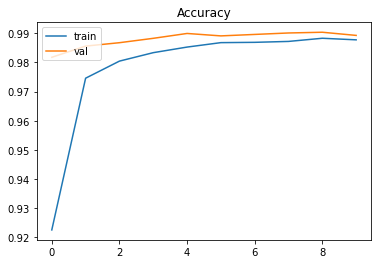

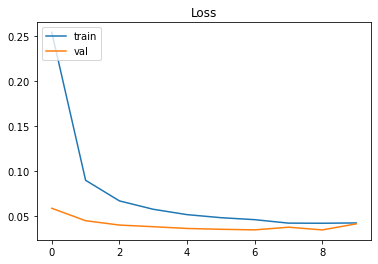

In [195]:

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()